In [1]:
!pip install bayesian-optimization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


In [3]:
epochs     = 100
batch_size = 32
window     = 30

# Parameters: Lorenz systems
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
num_steps = 10000
dt = 0.01


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Create dataset**

In [5]:
# Variables Initialization
x, y, z = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

# Initial conditions
x[0], y[0], z[0] = 0.0, 1.0, 20.0

for i in range(1, num_steps):
    x_dot = sigma * (y[i - 1] - x[i - 1])
    y_dot = x[i - 1] * (rho - z[i - 1]) - y[i - 1]
    z_dot = x[i - 1] * y[i - 1] - beta * z[i - 1]

    x[i] = x[i - 1] + x_dot * dt
    y[i] = y[i - 1] + y_dot * dt
    z[i] = z[i - 1] + z_dot * dt

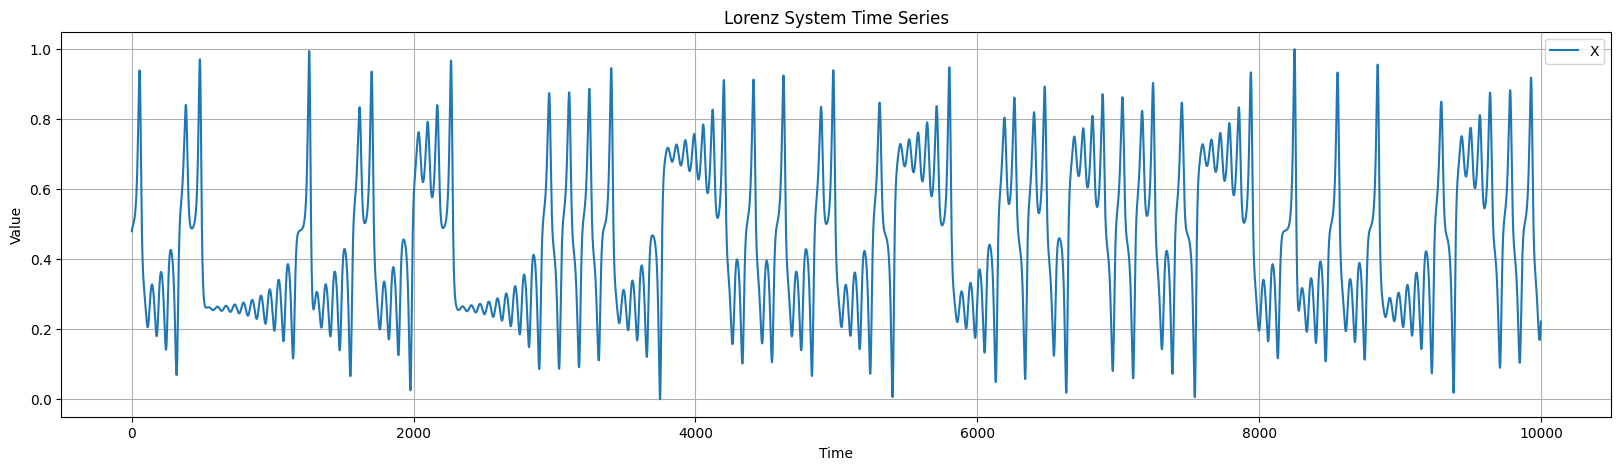

In [6]:
timeserie = x

# Normalization
timeserieNormalized = (timeserie-min(timeserie))/(max(timeserie)-min(timeserie))

plt.figure(figsize=(20, 5))
plt.plot(timeserieNormalized, label='X')
plt.title('Lorenz System Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
X = np.zeros([len(timeserieNormalized)-window, window])
for i in range(len(timeserieNormalized)-window):
  X[i,:] = timeserieNormalized[i:i+window].T
# Vector de salida (pronostico de nuestro modelo)
y = timeserieNormalized[window:]

X = X[:,:, np.newaxis]

X.shape, y.shape

((9970, 30, 1), (9970,))

In [8]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)


# **Custom Layer**

In [9]:
def _get_random_features_initializer(initializer, shape, seed=None):
    # Esta función debe retornar un arreglo numpy con la inicialización deseada.
    # Por ejemplo, si el initializer es 'gaussian':
    if seed is not None:
        np.random.seed(seed)
    if initializer == 'gaussian':
        # Por ejemplo, inicialización gaussiana estándar
        return np.random.randn(*shape)
    elif initializer == 'laplacian':
        # Por ejemplo, inicialización con distribución Laplaciana
        return np.random.laplace(loc=0.0, scale=1.0, size=shape)
    else:
        raise ValueError(f'Unsupported initializer {initializer}')


In [10]:
class Conv1dRFF_PT(nn.Module):
    def __init__(self, output_dim, kernel_size=3, scale=None, padding='VALID', normalization=True,
                 function=True, trainable_scale=False, trainable_W=False, seed=None, kernel='gaussian', **kwargs):
        super(Conv1dRFF_PT, self).__init__()
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.scale = scale
        # Reemplazamos 'VALID' por 0 para no padding
        self.padding = 0 if padding == 'VALID' else padding
        self.normalization = normalization
        self.function = function
        self.trainable_scale = trainable_scale
        self.trainable_W = trainable_W
        self.seed = seed
        self.initializer = kernel

        # Parámetros se inicializarán perezosamente la primera vez que se llame a forward
        self.kernel = None
        self.bias = None
        self.kernel_scale = None

    def forward(self, inputs):
        # Si los parámetros no están inicializados, los inicializamos ahora
        if self.kernel is None:
            input_shape = inputs.shape  # (batch_size, in_channels, length)
            input_dim = input_shape[1]

            kernel_initializer = _get_random_features_initializer(
                self.initializer,
                shape=(self.output_dim, input_dim, self.kernel_size),
                seed=self.seed
            )

            # Crear el kernel en el mismo device que 'inputs'
            kernel_initializer = torch.tensor(
                kernel_initializer,
                dtype=torch.float32,
                device=inputs.device
            )

            self.kernel = nn.Parameter(kernel_initializer, requires_grad=self.trainable_W)

            # Crear el bias en el mismo device
            self.bias = nn.Parameter(
                torch.empty(self.output_dim, device=inputs.device).uniform_(0.0, 2 * np.pi),
                requires_grad=self.trainable_W
            )

            # Set scale if not provided
            if self.scale is None:
                if self.initializer == 'gaussian':
                    self.scale = np.sqrt((input_dim * (self.kernel_size ** 2)) / 2.0)
                elif self.initializer == 'laplacian':
                    self.scale = 1.0
                else:
                    raise ValueError(f'Unsupported kernel initializer {self.initializer}')

            # Crear la kernel_scale en el mismo device
            self.kernel_scale = nn.Parameter(
                torch.tensor([self.scale], dtype=torch.float32, device=inputs.device),
                requires_grad=self.trainable_scale
            )

        scale = 1.0 / self.kernel_scale
        kernel = scale * self.kernel

        # Aplicar la convolución 1D
        outputs = F.conv1d(inputs, kernel, bias=self.bias, stride=1, padding=self.padding)

        # Si normalization es True:
        if self.normalization:
            # Crear el factor de escala sqrt(2 / output_dim) en el device correcto
            scale_factor = torch.sqrt(torch.tensor(2.0 / self.output_dim,
                                                   dtype=outputs.dtype,
                                                   device=outputs.device))

            if self.function:
                # outputs = scale_factor * cos(outputs)
                outputs = scale_factor * torch.cos(outputs)
            else:
                # condition = (outputs % 2 == 0)
                condition = (outputs % 2 == 0)
                # outputs = where(condition, scale_factor * cos(outputs), scale_factor * sin(outputs))
                outputs = torch.where(condition,
                                      scale_factor * torch.cos(outputs),
                                      scale_factor * torch.sin(outputs))
        else:
            # Si normalization es False
            if self.function:
                # outputs = cos(outputs)
                outputs = torch.cos(outputs)
            else:
                # condition = (outputs % 2 == 0)
                condition = (outputs % 2 == 0)
                # outputs = where(condition, cos(outputs), sin(outputs))
                outputs = torch.where(condition, torch.cos(outputs), torch.sin(outputs))

        return outputs



# **Dataset**

In [11]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((6380, 30, 1), (6380,), (1596, 30, 1), (1596,), (1994, 30, 1), (1994,))

In [12]:
X_train_t = torch.tensor(X_train.transpose(0, 2, 1), dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_valid_t = torch.tensor(X_valid.transpose(0, 2, 1), dtype=torch.float32)
y_valid_t = torch.tensor(y_valid.reshape(-1, 1), dtype=torch.float32)
X_test_t  = torch.tensor(X_test.transpose(0, 2, 1), dtype=torch.float32)
y_test_t  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

X_train_t.shape, y_train_t.shape, X_valid_t.shape, y_valid_t.shape, X_test_t.shape, y_test_t.shape

(torch.Size([6380, 1, 30]),
 torch.Size([6380, 1]),
 torch.Size([1596, 1, 30]),
 torch.Size([1596, 1]),
 torch.Size([1994, 1, 30]),
 torch.Size([1994, 1]))

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = X_train_t.to(device)
y_train_t = y_train_t.to(device)
X_valid_t = X_valid_t.to(device)
y_valid_t = y_valid_t.to(device)
X_test_t  = X_test_t.to(device)
y_test_t  = y_test_t.to(device)


# **Model**

In [14]:
class ForecastModel(nn.Module):
    def __init__(self, input_window=30, output_dim=100, kernel_size=5, horizon=1):
        super(ForecastModel, self).__init__()

        self.input_window = input_window
        self.output_dim   = output_dim
        self.kernel_size  = kernel_size
        self.horizon      = horizon

        self.conv_rff = Conv1dRFF_PT(
            output_dim=self.output_dim,
            kernel_size=self.kernel_size,
            seed=42,
            kernel='gaussian',
            padding='VALID',
            normalization=True,
            function=True
        )

        # Para padding='VALID' y stride=1:
        # length_out = input_window - kernel_size + 1
        self.length_out = self.input_window - self.kernel_size + 1

        self.flatten = nn.Flatten()
        # Fully connected
        self.fc = nn.Linear(self.output_dim * self.length_out, self.horizon)

    def forward(self, x):
        # x: (batch_size, 1, input_window)
        x = self.conv_rff(x)             # -> (batch_size, output_dim, length_out)
        x = self.flatten(x)              # -> (batch_size, output_dim * length_out)
        x = self.fc(x)                   # -> (batch_size, horizon)
        return x


In [15]:
def train_forecast_model(lr, wd, out_dim, k_size):
    """
    Entrena por pocas épocas el ForecastModel con los hiperparámetros
    pasados (lr, wd, out_dim, k_size) y devuelve -val_loss
    (porque BayesianOptimization maximiza la función objetivo).
    """
    # Convertir a int los parámetros que deben ser discretos
    out_dim = int(round(out_dim))
    k_size  = int(round(k_size))

    # Chequeo de rangos lógicos
    k_size  = max(1, min(k_size, 30))  # Evitar que k_size sea > 30 o < 1

    # 1) Crear el modelo y moverlo a GPU/CPU
    model = ForecastModel(input_window=30,
                          output_dim=out_dim,
                          kernel_size=k_size,
                          horizon=1).to(device)

    # 2) Definir criterio y optimizador
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # 3) Entrenar por pocas épocas para la evaluación
    epochs_to_train = 300
    batch_size = 1024

    train_size = X_train_t.shape[0]

    for epoch in range(epochs_to_train):
        model.train()
        permutation = np.random.permutation(train_size)

        for i in range(0, train_size, batch_size):
            idx = permutation[i : i+batch_size]
            X_batch = X_train_t[idx]
            Y_batch = y_train_t[idx]

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            loss.backward()
            optimizer.step()

    # 4) Validación
    model.eval()
    with torch.no_grad():
        preds_val = model(X_valid_t)
        val_loss = criterion(preds_val, y_valid_t).item()

    # Retornamos el negativo de val_loss
    return -val_loss

In [16]:
pbounds = {
    'lr':      (1e-5, 1e-2),
    'wd':      (1e-6, 1e-3),
    'out_dim': (100, 300),    # definimos un rango para out_dim
    'k_size':  (2, 10)        # definimos un rango para kernel_size
}

In [17]:
optimizer_bayes = BayesianOptimization(
    f=train_forecast_model,   # nuestra función objetivo
    pbounds=pbounds,
    verbose=2,
    random_state=42
)

In [22]:
optimizer_bayes.maximize(init_points=10, n_iter=10)


|   iter    |  target   |  k_size   |    lr     |  out_dim  |    wd     |
-------------------------------------------------------------------------
| 21        | -0.000271 | 2.976     | 0.004957  | 106.9     | 0.0009094 |
| 22        | -0.000174 | 4.07      | 0.006629  | 162.3     | 0.0005205 |
| 23        | -0.000725 | 6.374     | 0.001857  | 293.9     | 0.0007754 |
| 24        | -0.01061  | 9.516     | 0.008949  | 219.6     | 0.000922  |
| 25        | -0.000170 | 2.708     | 0.001968  | 109.0     | 0.000326  |
| 26        | -0.00151  | 5.109     | 0.002721  | 265.7     | 0.0003574 |
| 27        | -0.00089  | 4.247     | 0.005432  | 128.2     | 0.0008024 |
| 28        | -0.02475  | 2.596     | 0.009869  | 254.4     | 0.0001995 |
| 29        | -0.000573 | 2.044     | 0.008156  | 241.4     | 0.0007293 |
| 30        | -0.000330 | 8.17      | 0.0007497 | 171.7     | 0.0001168 |
| 31        | -0.000332 | 2.421     | 0.008723  | 222.3     | 0.0002356 |
| 32        | -0.004331 | 8.729     | 

In [23]:
print("Mejor resultado:")
print(optimizer_bayes.max)

Mejor resultado:
{'target': -4.597439692588523e-05, 'params': {'k_size': 3.0950864847374477, 'lr': 0.001962462020654448, 'out_dim': 294.5241029522764, 'wd': 6.047190500875179e-05}}


In [24]:
results = optimizer_bayes.res
iters = np.arange(1, len(results)+1)

In [25]:
targets = [res['target'] for res in results]
k_size_vals = [res['params']['k_size'] for res in results]
lr_vals     = [res['params']['lr']     for res in results]
out_dim_vals= [res['params']['out_dim']for res in results]
wd_vals     = [res['params']['wd']     for res in results]

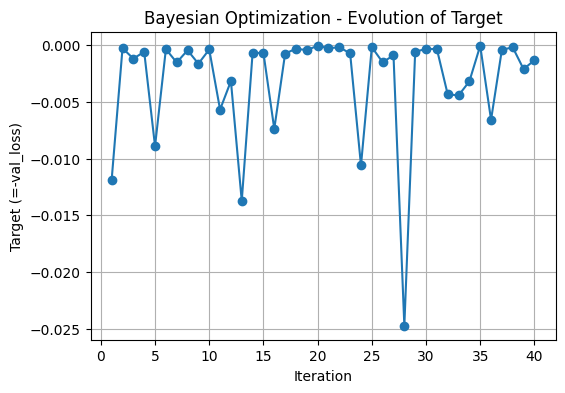

In [26]:
plt.figure(figsize=(6,4))
plt.plot(iters, targets, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Target (=-val_loss)")
plt.title("Bayesian Optimization - Evolution of Target")
plt.grid(True)
plt.show()

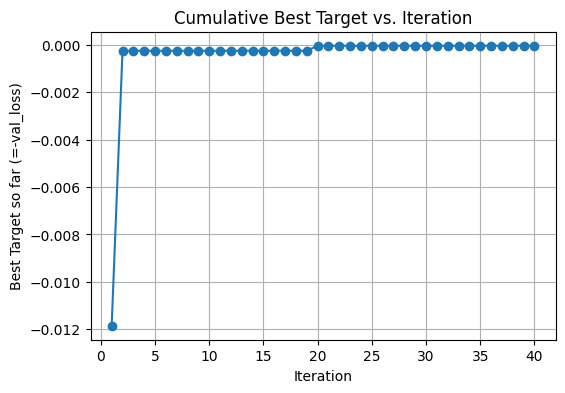

In [27]:
cum_best_target = []
best_so_far = float('-inf')
for val in targets:
    if val > best_so_far:
        best_so_far = val
    cum_best_target.append(best_so_far)

plt.figure(figsize=(6,4))
plt.plot(iters, cum_best_target, marker='o')
plt.title("Cumulative Best Target vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Best Target so far (=-val_loss)")
plt.grid(True)
plt.show()


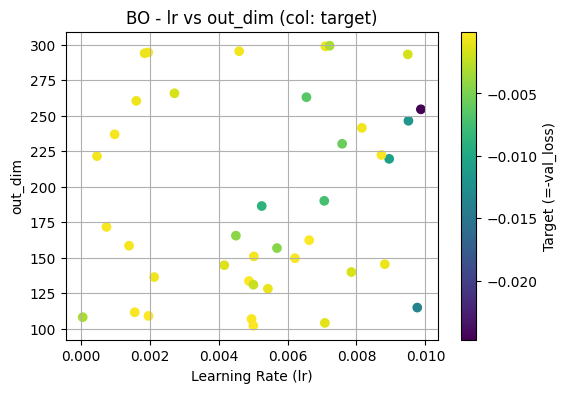

In [28]:
plt.figure(figsize=(6,4))
sc = plt.scatter(lr_vals, out_dim_vals, c=targets, cmap='viridis')
plt.colorbar(sc, label='Target (=-val_loss)')
plt.xlabel("Learning Rate (lr)")
plt.ylabel("out_dim")
plt.title("BO - lr vs out_dim (col: target)")
plt.grid(True)
plt.show()


In [29]:
import pandas as pd

df = pd.DataFrame({
    'k_size': k_size_vals,
    'lr': lr_vals,
    'out_dim': out_dim_vals,
    'wd': wd_vals,
    'target': targets
})

corr = df.corr()
print(corr['target'].sort_values(ascending=False))


target     1.000000
wd         0.082755
k_size     0.019694
out_dim   -0.148370
lr        -0.514564
Name: target, dtype: float64
